In [1]:
import matplotlib.pyplot as plt
import os
import json
import cv2
import numpy as np
import mediapipe as mp
import skimage
from skimage.transform import PiecewiseAffineTransform, warp
import cv2
import mediapipe as mp
import skimage
from skimage.transform import PiecewiseAffineTransform, warp
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import mediapipe as mp
from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import face_mesh as mp_face_mesh

import imgaug.augmenters as iaa
import random
import re
import os
import shutil

objc[24174]: Class CaptureDelegate is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x156672520) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x127d10860). One of the two will be used. Which one is undefined.
objc[24174]: Class CVWindow is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x156672570) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x121ac4a68). One of the two will be used. Which one is undefined.
objc[24174]: Class CVView is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x156672598) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (

objc[24716]: Class CaptureDelegate is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x159372520) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x130170860). One of the two will be used. Which one is undefined.
objc[24716]: Class CVWindow is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x159372570) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x110c24a68). One of the two will be used. Which one is undefined.
objc[24716]: Class CVView is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x159372598) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (

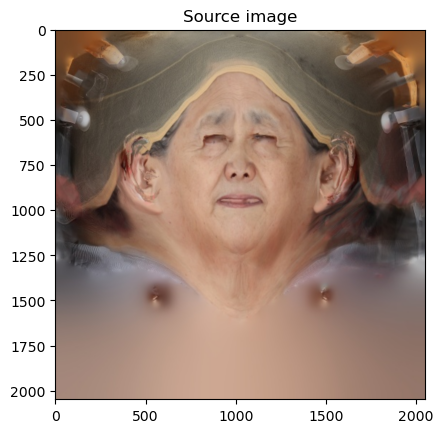

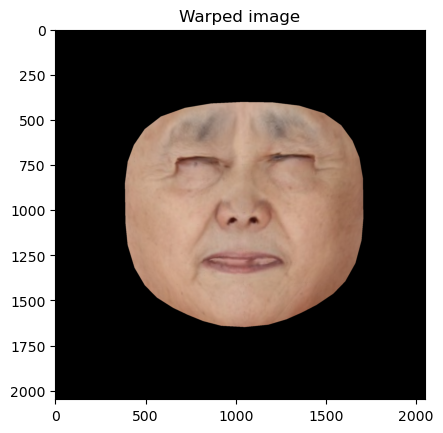

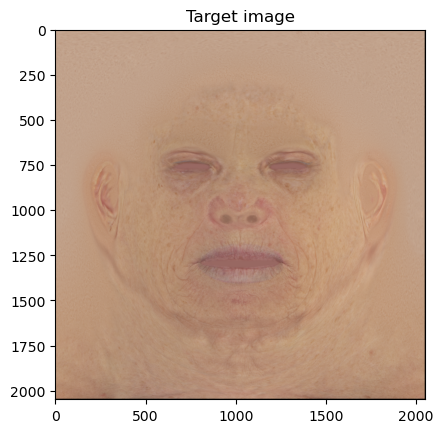

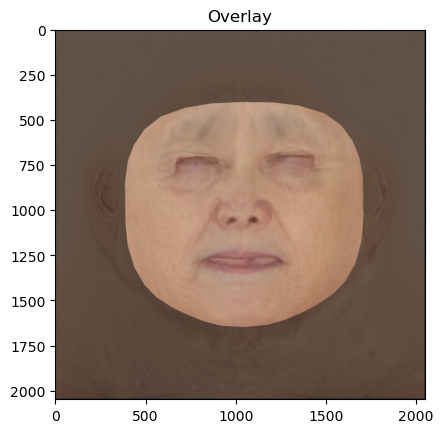

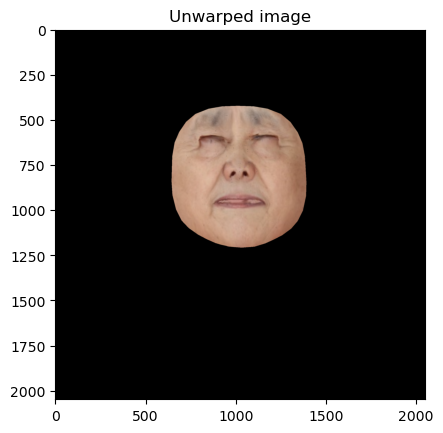

In [1]:
from scipy.spatial import Delaunay
import cv2
import numpy as np
import mediapipe as mp
import skimage
from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import face_mesh as mp_face_mesh
import matplotlib.pyplot as plt

def get_landmarks(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for i in range(0, 468):
                landmark = face_landmarks.landmark[i]
                x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
                landmarks.append((x, y))
    return np.array(landmarks)

def warp_image(image1, image2, landmarks1, landmarks2):
    # Compute Delaunay Triangulation
    delaunay = Delaunay(landmarks1)
    warped_image = np.zeros_like(image1)
    
    # Iterate through each triangle in the triangulation
    for simplex in delaunay.simplices:
        # Get the vertices of the triangle in both images
        src_triangle = landmarks1[simplex]
        dest_triangle = landmarks2[simplex]

        # Compute the bounding box of the triangle in both images
        src_rect = cv2.boundingRect(np.float32([src_triangle]))
        dest_rect = cv2.boundingRect(np.float32([dest_triangle]))

        # Crop the triangle from the source and destination images
        src_cropped_triangle = image1[src_rect[1]:src_rect[1] + src_rect[3], src_rect[0]:src_rect[0] + src_rect[2]]
        dest_cropped_triangle = np.zeros((dest_rect[3], dest_rect[2], 3), dtype=np.float32)

        # Adjust coordinates to the cropped region
        src_triangle_adjusted = src_triangle - (src_rect[0], src_rect[1])
        dest_triangle_adjusted = dest_triangle - (dest_rect[0], dest_rect[1])

        # Compute the affine transformation
        matrix = cv2.getAffineTransform(np.float32(src_triangle_adjusted), np.float32(dest_triangle_adjusted))

        # Warp the source triangle to the shape of the destination triangle
        warped_triangle = cv2.warpAffine(src_cropped_triangle, matrix, (dest_rect[2], dest_rect[3]))

        # Mask for the destination triangle
        mask = np.zeros((dest_rect[3], dest_rect[2]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dest_triangle_adjusted), (1, 1, 1), 16, 0)

        # Place the warped triangle in the destination image
        warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] = \
            warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] * (1 - mask[:, :, None]) \
            + warped_triangle * mask[:, :, None]

    return warped_image.astype(np.uint8)

image1 = cv2.imread(r"1_neutral.jpg")
image2 = cv2.imread(r"images/models_4k/m32.png")
WIDTH = 2048
HEIGHT = 2048
image2 = cv2.resize(image2, (WIDTH, HEIGHT))
image1 = cv2.resize(image1, (WIDTH, HEIGHT))

landmarks1 = get_landmarks(image1)
landmarks2 = get_landmarks(image2)

# Warp image1 to align with image2
warped_image1 = warp_image(image1, image2, landmarks1, landmarks2)

warped_landmarks1 = get_landmarks(warped_image1)

plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title("Source image")
plt.show()
plt.imshow(cv2.cvtColor(warped_image1, cv2.COLOR_BGR2RGB))
plt.title("Warped image")
plt.show()

plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title("Target image")
plt.show()

#plot 1 on top of 2 with alpha 0.5
alpha = 0.5
beta = (1.0 - alpha)
dst = cv2.addWeighted(warped_image1, alpha, image2, beta, 0.0)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title("Overlay")
plt.show()

unwarped_image = warp_image(warped_image1, image1, warped_landmarks1, landmarks1)
plt.imshow(cv2.cvtColor(unwarped_image, cv2.COLOR_BGR2RGB))
plt.title("Unwarped image")
plt.show()

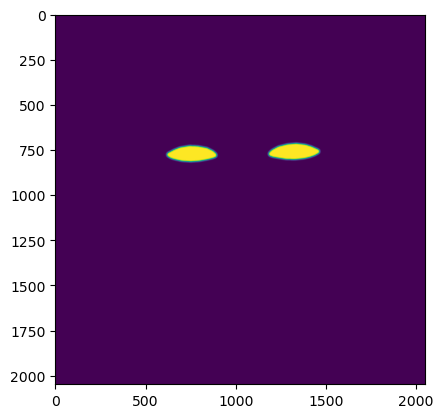

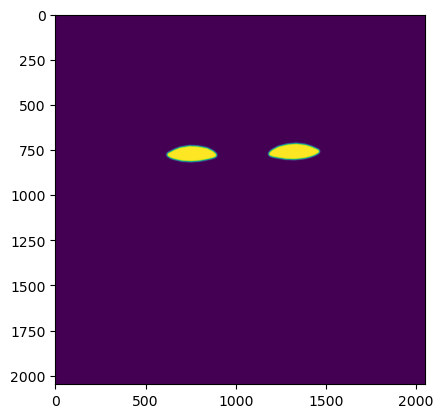

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Read the image
image = cv2.imread('eye_mask.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
plt.show()
# Threshold the image to get binary image
_, thresh = cv2.threshold(image, 15, 255, cv2.THRESH_BINARY)

# Find the contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask
mask = np.zeros_like(image)

# Draw the contour on the mask
cv2.drawContours(mask, contours, -1, (255), thickness=5)

# Apply erosion to shrink the contour
kernel_size = 15 # Change this to adjust the amount of shrinking
kernel = np.ones((kernel_size,kernel_size), np.uint8)
eroded_mask = cv2.erode(mask, kernel, iterations=10)

# Find the shrunk contour
shrunk_contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the original and shrunk contours on the image
cv2.drawContours(image, contours, -1, (0), 2)
cv2.drawContours(image, shrunk_contours, -1, (127), 2)

# Show the image
cv2.imshow('Shrunk Contours', image)
plt.imshow(image)
plt.show()


In [11]:
from scipy.spatial import Delaunay
from scipy.interpolate import Rbf
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
def compute_perimeter(landmarks):
    perimeter = 0
    for i in range(len(landmarks) - 1):
        perimeter += np.linalg.norm(landmarks[i+1] - landmarks[i])
    return perimeter

def get_landmarks(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for i in range(0, 468):
                landmark = face_landmarks.landmark[i]
                x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
                landmarks.append((x, y))
    return np.array(landmarks)

def warp_image(image, src_landmarks, dest_landmarks):
    rbf_x = Rbf(src_landmarks[:, 0], src_landmarks[:, 1], dest_landmarks[:, 0], function='thin_plate', smooth=0)
    rbf_y = Rbf(src_landmarks[:, 0], src_landmarks[:, 1], dest_landmarks[:, 1], function='thin_plate', smooth=0)

    grid_y, grid_x = np.mgrid[0:image.shape[0]:1, 0:image.shape[1]:1]
    dest_x = rbf_x(grid_x, grid_y)
    dest_y = rbf_y(grid_x, grid_y)

    map_x = dest_x.astype(np.float32)
    map_y = dest_y.astype(np.float32)

    warped_image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return warped_image

# Read the images
image1 = cv2.imread(r"1_neutral.jpg")
WIDTH = image1.shape[1]
HEIGHT = image1.shape[0]
image2 = cv2.imread(r"images/models_4k/m32.png")
image2 = cv2.resize(image2, (WIDTH, HEIGHT))

# Get landmarks from both images
landmarks1 = get_landmarks(image1)
landmarks2 = get_landmarks(image2)
# Compute the perimeters of both faces
perimeter1 = compute_perimeter(landmarks1)
perimeter2 = compute_perimeter(landmarks2)

# Compute a scaling factor based on the perimeters
scaling_factor = perimeter2 / perimeter1 if perimeter1 != 0 else 1

# Resize image1 before warping
image1_resized = cv2.resize(image1, (int(WIDTH * scaling_factor), int(HEIGHT * scaling_factor)))

# Recompute landmarks for resized image1
landmarks1_resized = get_landmarks(image1_resized)

# Warp the resized image to align it with the second
warped_image1 = warp_image(image1_resized, landmarks1_resized, landmarks2)

# Display the results
plt.imshow(warped_image1[:, :, ::-1])
plt.show()


# Warp the first image to align it with the second
warped_image1 = warp_image(image1, landmarks1, landmarks2)
plt.imshow(image2)
plt.show()
# Display the results
plt.imshow(warped_image1[:, :, ::-1])
plt.show()

def triangulate(landmarks):
    return Delaunay(landmarks).simplices

def warp_triangles(image, src_landmarks, dest_landmarks, triangles):
    result = np.zeros_like(image)
    for simplex in triangles:
        src_triangle = np.array([src_landmarks[simplex[0]], src_landmarks[simplex[1]], src_landmarks[simplex[2]]], np.int32)
        dest_triangle = np.array([dest_landmarks[simplex[0]], dest_landmarks[simplex[1]], dest_landmarks[simplex[2]]], np.int32)
        
        # Compute the affine transformation
        matrix = cv2.getAffineTransform(np.float32(src_triangle), np.float32(dest_triangle))
        warped_triangle = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        
        # Mask the destination triangle
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, dest_triangle, 1)
        mask = mask.astype(bool)
        
        # Add the triangle to the result image
        result[mask] = warped_triangle[mask]
        
    return result

triangles = triangulate(landmarks1_resized)
warped_image1_tri = warp_triangles(image1_resized, landmarks1_resized, landmarks2, triangles)

# Display the results
plt.imshow(warped_image1_tri[:, :, ::-1])
plt.show()



KeyboardInterrupt: 

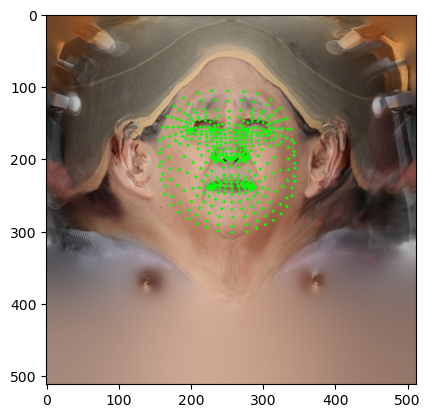

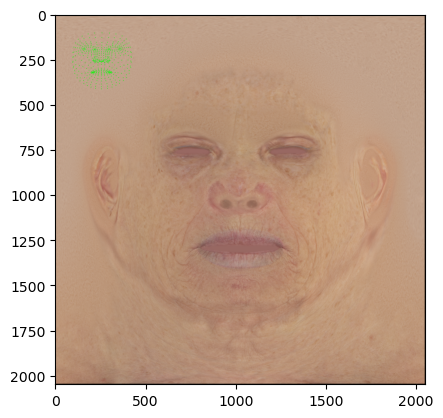

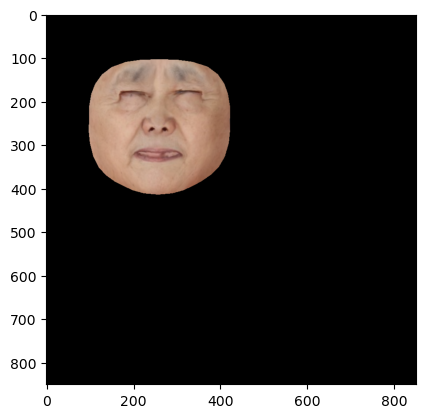

In [13]:
def draw_landmarks(image, landmarks):
    overlay = image.copy()
    for (x, y) in landmarks:
        cv2.circle(overlay, (x, y), 2, (0, 255, 0), -1)
    return overlay
# Read the images
image1 = cv2.imread(r"1_neutral.jpg")
WIDTH = image1.shape[1]
HEIGHT = image1.shape[0]
image2 = cv2.imread(r"images/models_4k/m32.png")
# image2 = cv2.resize(image2, (WIDTH, HEIGHT))
# Display landmarks for both images
plt.imshow(draw_landmarks(image1, landmarks1)[:, :, ::-1])
plt.show()

plt.imshow(draw_landmarks(image2, landmarks2)[:, :, ::-1])
plt.show()

def triangulate(landmarks):
    return Delaunay(landmarks).simplices

def warp_triangles(image, src_landmarks, dest_landmarks, triangles):
    result = np.zeros_like(image)
    for simplex in triangles:
        src_triangle = np.array([src_landmarks[simplex[0]], src_landmarks[simplex[1]], src_landmarks[simplex[2]]], np.int32)
        dest_triangle = np.array([dest_landmarks[simplex[0]], dest_landmarks[simplex[1]], dest_landmarks[simplex[2]]], np.int32)
        
        # Compute the affine transformation
        matrix = cv2.getAffineTransform(np.float32(src_triangle), np.float32(dest_triangle))
        warped_triangle = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        
        # Mask the destination triangle
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, dest_triangle, 1)
        mask = mask.astype(bool)
        
        # Add the triangle to the result image
        result[mask] = warped_triangle[mask]
        
    return result

triangles = triangulate(landmarks1_resized)
warped_image1_tri = warp_triangles(image1_resized, landmarks1_resized, landmarks2, triangles)

# Display the results
plt.imshow(warped_image1_tri[:, :, ::-1])
plt.show()


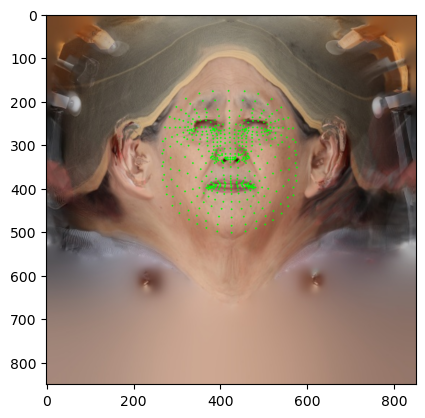

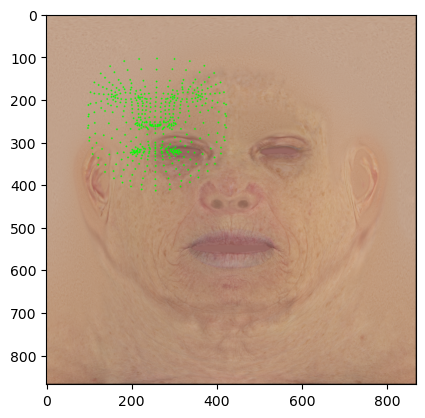

In [18]:
def scale_landmarks(landmarks, scaling_factor):
    return landmarks * scaling_factor

# Scale the landmarks
landmarks1_resized = scale_landmarks(landmarks1, scaling_factor=1.6954053946146244)
# Compute the new dimensions
new_width = int(WIDTH * scaling_factor)
new_height = int(HEIGHT * scaling_factor)

# Resize the destination image
image2_resized = cv2.resize(image2, (new_width, new_height))
# Get landmarks from resized image1
landmarks1_resized = get_landmarks(image1_resized)

plt.imshow(draw_landmarks(image1_resized, landmarks1_resized)[:, :, ::-1])
plt.show()

plt.imshow(draw_landmarks(image2_resized, landmarks2)[:, :, ::-1])
plt.show()


In [20]:
def compute_contour_length(landmarks, contour_indices):
    length = 0
    for i in range(len(contour_indices) - 1):
        length += np.linalg.norm(landmarks[contour_indices[i + 1]] - landmarks[contour_indices[i]])
    return length

def compute_face_perimeter(landmarks):
    perimeter = 0
    for i in range(len(landmarks) - 1):
        perimeter += np.linalg.norm(landmarks[i + 1] - landmarks[i])
    perimeter += np.linalg.norm(landmarks[-1] - landmarks[0]) # Close the loop
    return perimeter

perimeter1 = compute_face_perimeter(landmarks1)
perimeter2 = compute_face_perimeter(landmarks2)

print("Perimeter 1: ", perimeter1)
print("Perimeter 2: ", perimeter2)
scale_factor = perimeter2 / perimeter1 if perimeter1 != 0 else 1
print("Scale factor: ", scale_factor)
# Example for jawline contour using a 68-point model
jawline_indices = np.arange(0, 17)

length1 = compute_contour_length(landmarks1, jawline_indices)
length2 = compute_contour_length(landmarks2, jawline_indices)
scaling_factor = length2 / length1 if length1 != 0 else 1

print("Scaling factor: ", scaling_factor)

Perimeter 1:  17483.634121765626
Perimeter 2:  29066.60684833997
Scale factor:  1.6625037246778422
Scaling factor:  1.6954053946146244


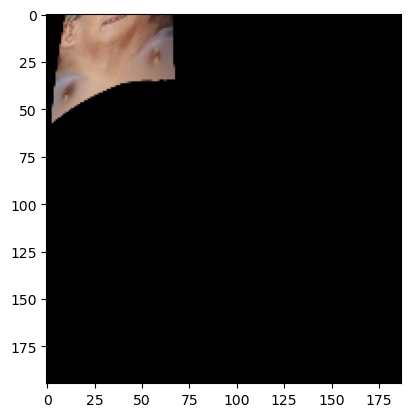

In [22]:
def bounding_box(landmarks):
    min_x = min(landmarks[:, 0])
    max_x = max(landmarks[:, 0])
    min_y = min(landmarks[:, 1])
    max_y = max(landmarks[:, 1])
    return (min_x, min_y, max_x, max_y)

bbox1 = bounding_box(landmarks1)
bbox2 = bounding_box(landmarks2)
scaling_factor_x = (bbox2[2] - bbox2[0]) / (bbox1[2] - bbox1[0]) if bbox1[2] - bbox1[0] != 0 else 1
scaling_factor_y = (bbox2[3] - bbox2[1]) / (bbox1[3] - bbox1[1]) if bbox1[3] - bbox1[1] != 0 else 1
cropped_image1 = image1[bbox1[1]:bbox1[3], bbox1[0]:bbox1[2]]
cropped_resized_image1 = cv2.resize(cropped_image1, (int(cropped_image1.shape[1] * scaling_factor_x), int(cropped_image1.shape[0] * scaling_factor_y)))
landmarks1_cropped_resized = get_landmarks(cropped_resized_image1)
warped_image1 = warp_image(cropped_resized_image1, landmarks1_cropped_resized, landmarks2)

plt.imshow(warped_image1[:, :, ::-1])
plt.show()

objc[22475]: Class CaptureDelegate is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x133372520) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x135498860). One of the two will be used. Which one is undefined.
objc[22475]: Class CVWindow is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x133372570) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x13095ca68). One of the two will be used. Which one is undefined.
objc[22475]: Class CVView is implemented in both /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x133372598) and /Users/joeljohnson/opt/anaconda3/envs/mediapipe/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (

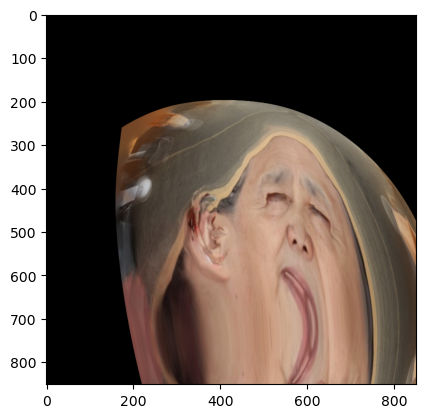

In [1]:
from scipy.interpolate import Rbf
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

def get_landmarks(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for i in range(0, 468):
                landmark = face_landmarks.landmark[i]
                x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
                landmarks.append((x, y))
    return np.array(landmarks)

def warp_image(image, src_landmarks, dest_landmarks):
    rbf_x = Rbf(src_landmarks[:, 0], src_landmarks[:, 1], dest_landmarks[:, 0], function='thin_plate', smooth=0)
    rbf_y = Rbf(src_landmarks[:, 0], src_landmarks[:, 1], dest_landmarks[:, 1], function='thin_plate', smooth=0)
    grid_y, grid_x = np.mgrid[0:image.shape[0]:1, 0:image.shape[1]:1]
    dest_x = rbf_x(grid_x, grid_y)
    dest_y = rbf_y(grid_x, grid_y)
    map_x = dest_x.astype(np.float32)
    map_y = dest_y.astype(np.float32)
    warped_image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return warped_image

def compute_perimeter(landmarks):
    perimeter = 0
    for i in range(len(landmarks) - 1):
        perimeter += np.linalg.norm(landmarks[i+1] - landmarks[i])
    return perimeter

def align_landmarks(landmarks1, landmarks2):
    center1 = np.mean(landmarks1, axis=0)
    center2 = np.mean(landmarks2, axis=0)
    translated_landmarks1 = landmarks1 - center1 + center2
    perimeter1 = compute_perimeter(landmarks1)
    perimeter2 = compute_perimeter(landmarks2)
    scaling_factor = perimeter2 / perimeter1 if perimeter1 != 0 else 1
    scaled_landmarks1 = translated_landmarks1 * scaling_factor
    return scaled_landmarks1, scaling_factor

def draw_landmarks(image, landmarks):
    for landmark in landmarks:
        cv2.circle(image, tuple(landmark), 1, (0, 0, 255), -1)
    return image

image1 = cv2.imread(r"1_neutral.jpg")
image2 = cv2.imread(r"images/models_4k/m32.png")
WIDTH = 512
HEIGHT = 512
image2 = cv2.resize(image2, (WIDTH, HEIGHT))
image1 = cv2.resize(image1, (WIDTH, HEIGHT))
landmarks1 = get_landmarks(image1)
landmarks2 = get_landmarks(image2)
scaled_landmarks1, scaling_factor = align_landmarks(landmarks1, landmarks2)
resized_image1 = cv2.resize(image1, (0, 0), fx=scaling_factor, fy=scaling_factor)
warped_image1 = warp_image(resized_image1, scaled_landmarks1, landmarks2)
plt.imshow(cv2.cvtColor(warped_image1, cv2.COLOR_BGR2RGB))
plt.show()


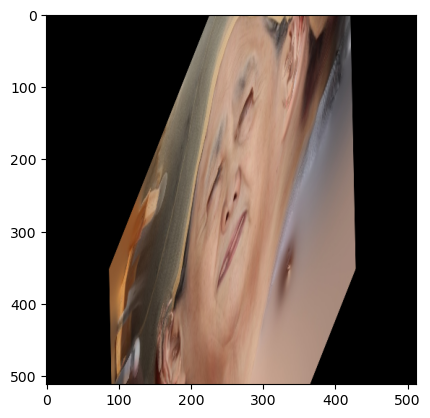

In [4]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

def get_landmarks(image):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for i in range(0, 468):
                landmark = face_landmarks.landmark[i]
                x, y = int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0])
                landmarks.append((x, y))
    return np.array(landmarks)

def warp_image(image, src_landmarks, dest_landmarks):
    # Select three corresponding points to compute affine transformation
    src_pts = np.float32([src_landmarks[0], src_landmarks[1], src_landmarks[2]])
    dest_pts = np.float32([dest_landmarks[0], dest_landmarks[1], dest_landmarks[2]])
    matrix = cv2.getAffineTransform(src_pts, dest_pts)
    warped_image = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return warped_image


image1 = cv2.imread(r"1_neutral.jpg")
image2 = cv2.imread(r"images/models_4k/m32.png")
WIDTH = 512
HEIGHT = 512
image2 = cv2.resize(image2, (WIDTH, HEIGHT))
image1 = cv2.resize(image1, (WIDTH, HEIGHT))
landmarks1 = get_landmarks(image1)
landmarks2 = get_landmarks(image2)

# Make sure both landmark arrays have the same shape
if landmarks1.shape != landmarks2.shape:
    raise ValueError("Landmark shapes do not match!")

warped_image1 = warp_image(image1, landmarks1, landmarks2)

plt.imshow(cv2.cvtColor(warped_image1, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
from scipy.spatial import Delaunay
import cv2
import numpy as np

# Other functions as previously defined

def warp_image(image1, image2, landmarks1, landmarks2):
    # Compute Delaunay Triangulation
    delaunay = Delaunay(landmarks1)
    warped_image = np.zeros_like(image1)
    
    # Iterate through each triangle in the triangulation
    for simplex in delaunay.simplices:
        # Get the vertices of the triangle in both images
        src_triangle = landmarks1[simplex]
        dest_triangle = landmarks2[simplex]

        # Compute the bounding box of the triangle in both images
        src_rect = cv2.boundingRect(np.float32([src_triangle]))
        dest_rect = cv2.boundingRect(np.float32([dest_triangle]))

        # Crop the triangle from the source and destination images
        src_cropped_triangle = image1[src_rect[1]:src_rect[1] + src_rect[3], src_rect[0]:src_rect[0] + src_rect[2]]
        dest_cropped_triangle = np.zeros((dest_rect[3], dest_rect[2], 3), dtype=np.float32)

        # Adjust coordinates to the cropped region
        src_triangle_adjusted = src_triangle - (src_rect[0], src_rect[1])
        dest_triangle_adjusted = dest_triangle - (dest_rect[0], dest_rect[1])

        # Compute the affine transformation
        matrix = cv2.getAffineTransform(np.float32(src_triangle_adjusted), np.float32(dest_triangle_adjusted))

        # Warp the source triangle to the shape of the destination triangle
        warped_triangle = cv2.warpAffine(src_cropped_triangle, matrix, (dest_rect[2], dest_rect[3]))

        # Mask for the destination triangle
        mask = np.zeros((dest_rect[3], dest_rect[2]), dtype=np.uint8)
        cv2.fillConvexPoly(mask, np.int32(dest_triangle_adjusted), (1, 1, 1), 16, 0)

        # Place the warped triangle in the destination image
        warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] = \
            warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] * (1 - mask[:, :, None]) \
            + warped_triangle * mask[:, :, None]

    return warped_image.astype(np.uint8)
def unwarp_image(warped_image, image2, landmarks1, landmarks2):
    delaunay = Delaunay(landmarks2)
    unwarped_image = np.zeros_like(image2, dtype=np.float32)
    mask = np.zeros_like(image2)
    
    for simplex in delaunay.simplices:
        dest_triangle = landmarks2[simplex]
        src_triangle = landmarks1[simplex]

        dest_rect = cv2.boundingRect(np.float32([dest_triangle]))
        src_rect = cv2.boundingRect(np.float32([src_triangle]))

        dest_cropped_triangle = warped_image[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]]
        src_cropped_triangle = np.zeros((src_rect[3], src_rect[2], 3), dtype=np.float32)

        dest_triangle_adjusted = dest_triangle - (dest_rect[0], dest_rect[1])
        src_triangle_adjusted = src_triangle - (src_rect[0], src_rect[1])

        matrix = cv2.getAffineTransform(np.float32(dest_triangle_adjusted), np.float32(src_triangle_adjusted))
        unwarped_triangle = cv2.warpAffine(dest_cropped_triangle, matrix, (src_rect[2], src_rect[3]))

        triangle_mask = np.zeros((src_rect[3], src_rect[2]), dtype=np.uint8)
        cv2.fillConvexPoly(triangle_mask, np.int32(src_triangle_adjusted), 1)
        triangle_mask = triangle_mask[:, :, np.newaxis] # Extend to 3-channel mask

        src_cropped_triangle += unwarped_triangle * triangle_mask
        mask[src_rect[1]:src_rect[1] + src_rect[3], src_rect[0]:src_rect[0] + src_rect[2]] += triangle_mask
        unwarped_image[src_rect[1]:src_rect[1] + src_rect[3], src_rect[0]:src_rect[0] + src_rect[2]] += src_cropped_triangle
        
    # Smooth the mask and apply it
    mask_smoothed = cv2.GaussianBlur(mask, (5, 5), 0) / 255.0
    unwarped_image = unwarped_image / (mask_smoothed + 1e-5)[:, :, None]
    unwarped_image = np.clip(unwarped_image, 0, 255).astype(np.uint8)

    return unwarped_image

image1 = cv2.imread(r"1_neutral.jpg")
image2 = cv2.imread(r"images/models_4k/m32.png")
WIDTH = 512
HEIGHT = 512
image2 = cv2.resize(image2, (WIDTH, HEIGHT))
image1 = cv2.resize(image1, (WIDTH, HEIGHT))

landmarks1 = get_landmarks(image1)
landmarks2 = get_landmarks(image2)

# Warp image1 to align with image2
warped_image1 = warp_image(image1, image2, landmarks1, landmarks2)

plt.imshow(cv2.cvtColor(warped_image1, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.show()

#plot 1 on top of 2 with alpha 0.5
alpha = 0.5
beta = (1.0 - alpha)
dst = cv2.addWeighted(warped_image1, alpha, image2, beta, 0.0)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

unwarped_image = unwarp_image(warped_image1, image2, landmarks1, landmarks2)
plt.imshow(cv2.cvtColor(unwarped_image, cv2.COLOR_BGR2RGB))
plt.show()